<a href="https://colab.research.google.com/github/sanjayssane/SessionsMaterial/blob/main/notebooks/modelscope-to-openvino/modelscope-to-openvino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert models from ModelScope to OpenVINO

![](https://camo.githubusercontent.com/bbda58b4f77b80d9206e3410b533ca5a2582b81070e7dd283ee12fd0d442bd2b/68747470733a2f2f6d6f64656c73636f70652e6f73732d636e2d6265696a696e672e616c6979756e63732e636f6d2f6d6f64656c73636f70652e676966)

[ModelScope](https://www.modelscope.cn/home) is a “Model-as-a-Service” (MaaS) platform that seeks to bring together most advanced machine learning models from the AI community, and to streamline the process of leveraging AI models in real applications. Hundreds of models are made publicly available on ModelScope (700+ and counting), covering the latest development in areas such as NLP, CV, Audio, Multi-modality, and AI for Science, etc. Many of these models represent the SOTA in their specific fields, and made their open-sourced debut on ModelScope.

This tutorial covers how to use the modelscope ecosystem within OpenVINO.



### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/modelscope-to-openvino/modelscope-to-openvino.ipynb" />

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert models from ModelScope using OpenVINO Model Conversion API](#Convert-models-from-ModelScope-using-OpenVINO-Model-Conversion-API)
    - [Select inference device for image classification](#Select-inference-device-for-image-classification)
    - [Run Image classification](#Run-Image-classification)
- [Convert ModelScope models using Optimum Intel](#Convert-ModelScope-models-using-Optimum-Intel)
    - [Select inference device for text classification](#Select-inference-device-for-text-classification)
    - [Perform text classification](#Perform-text-classification)
- [Convert ModelScope models for usage with OpenVINO GenAI](#Convert-ModelScope-models-for-usage-with-OpenVINO-GenAI)
    - [Select inference device for text generation](#Select-inference-device-for-text-generation)
    - [Run OpenVINO GenAI pipeline](#Run-OpenVINO-GenAI-pipeline)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import requests
from pathlib import Path
import platform


if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    with open("notebook_utils.py", "w") as f:
        f.write(r.text)

if not Path("pip_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/pip_helper.py",
    )
    open("pip_helper.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )
    with open("cmd_helper.py", "w") as f:
        f.write(r.text)


from pip_helper import pip_install


pip_install("-qU", "torch>=2.6", "torchvision", "--extra-index-url", "https://download.pytorch.org/whl/cpu")
pip_install("-q", "modelscope", "addict", "oss2", "simplejson", "sortedcontainers", "pillow", "opencv-python", "datasets<=3.0.0")
pip_install("-q", "transformers>=4.45", "git+https://github.com/huggingface/optimum-intel.git", "--extra-index-url", "https://download.pytorch.org/whl/cpu")
pip_install("-qU", "openvino>=2024.5.0", "openvino-tokenizers>=2024.5.0", "openvino-genai>=2024.5.0", "nncf>=2.14.0")


if platform.system() == "Darwin":
    pip_install("-q", "numpy<2.0.0")


# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("modelscope-to-openvino.ipynb")

## Convert models from ModelScope using OpenVINO Model Conversion API
[back to top ⬆️](#Table-of-contents:)

Modelscope package provides API for initializing a model and loading a set of pre-trained weights using the model text handle.
Discovering a desired model name is straightforward with [Modelscope models web page](https://www.modelscope.cn/models), one can choose a model solving a particular machine learning problem and even sort the models by popularity and novelty.

OpenVINO supports various types of models and frameworks via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

As example, we will use [tinynas](https://www.modelscope.cn/models/iic/cv_tinynas_classification) image classification model. The code bellow demonstrates how to load this model using Modelscope pipelines interface, convert it to OpenVINO IR and then perform image classification on specified device.


In [2]:
from pathlib import Path

from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
import openvino as ov
import torch
import gc


cls_model_id = "iic/cv_tinynas_classification"
cls_model_path = Path(cls_model_id.split("/")[-1]) / "openvino_model.xml"

if not cls_model_path.exists():
    # load Modelcope pipeline with model
    image_classification = pipeline(Tasks.image_classification, model=cls_model_id)
    # convert model to OpenVINO
    ov_model = ov.convert_model(image_classification.model, example_input=torch.zeros((1, 3, 224, 224)), input=[1, 3, 224, 224])
    # save OpenVINO model on disk for next usage
    ov.save_model(ov_model, cls_model_path)
    del ov_model
    del image_classification
    gc.collect();

2025-11-18 12:28:33,910 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0


2025-11-18 12:28:39,295 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2025-11-18 12:28:39,566 - modelscope - INFO - Got 5 files, start to download ...


Processing 5 items:   0%|          | 0.00/5.00 [00:00<?, ?it/s]

2025-11-18 12:29:28,578 - modelscope - INFO - Download model 'iic/cv_tinynas_classification' successfully.
2025-11-18 12:29:28,590 - modelscope - INFO - initiate model from /root/.cache/modelscope/hub/models/iic/cv_tinynas_classification
2025-11-18 12:29:28,591 - modelscope - INFO - initiate model from location /root/.cache/modelscope/hub/models/iic/cv_tinynas_classification.
2025-11-18 12:29:28,596 - modelscope - WARNING - No preprocessor field found in cfg.
2025-11-18 12:29:28,596 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2025-11-18 12:29:28,597 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': '/root/.cache/modelscope/hub/models/iic/cv_tinynas_classification'}. trying to build by task and model information.
2025-11-18 12:29:28,598 - modelscope - WARNING - Find task: image-classification, model type: None. Insufficient information to build preproc

### Select inference device for image classification
[back to top ⬆️](#Table-of-contents:)

In [3]:
from notebook_utils import device_widget

cv_cls_device = device_widget("CPU")

cv_cls_device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

### Run Image classification
[back to top ⬆️](#Table-of-contents:)

Model inference interface remains compatible with pipeline preprocessing and postprocessing, so you can reuse these part of pipeline, but for providing standalone experience, we will demonstrate how to use model without pipeline. The code bellow defines utilities for image preprocessing and postprocessing.

In [4]:
from notebook_utils import download_file
from PIL import Image
from torchvision import transforms

# prepare input data and output lables
img_url = "https://github.com/user-attachments/assets/9d75c316-6522-4e67-997e-f6879d1d5de8"
img_path = Path("dog.png")

labels_url = "https://raw.githubusercontent.com/openvinotoolkit/open_model_zoo/master/data/dataset_classes/imagenet_2012.txt"

labels_path = Path("imagenet_2012.txt")

if not img_path.exists():
    download_file(img_url, img_path)

if not labels_path.exists():
    download_file(labels_url)

image = Image.open(img_path)
imagenet_classes = labels_path.open("r").read().splitlines()


# prepare image preprocessing
transforms_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_list = [
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms_normalize,
]
transformer = transforms.Compose(transform_list)

# compile model
core = ov.Core()

ov_model = core.compile_model(cls_model_path, cv_cls_device.value)

dog.png:   0%|          | 0.00/416k [00:00<?, ?B/s]

imagenet_2012.txt:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

Now, when we make all necessary preparations, we can run model inference.

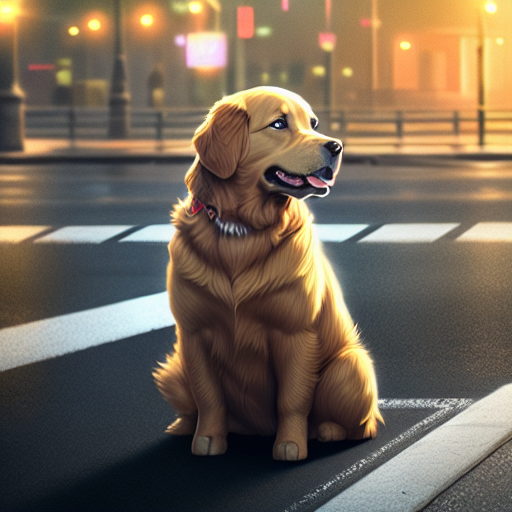

Predicted label: n02099601 golden retriever, score 8.777854919433594


In [5]:
import numpy as np

# preprocess input
image_tensor = transformer(image)

# run model inference
result = ov_model(image_tensor.unsqueeze(0))[0]

# postprocess results
label_id = np.argmax(result[0])
score = result[0][label_id]

label = imagenet_classes[label_id]

# visualize results
display(image)
print(f"Predicted label: {label}, score {score}")

## Convert ModelScope models using Optimum Intel
[back to top ⬆️](#Table-of-contents:)

For models compatible with the [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) library, we can use [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) integration to convert and run model. 🤗 Optimum Intel is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Optimum Intel provides a simple interface for optimizing your Transformers and Diffusers models, converting them to the OpenVINO Intermediate Representation (IR) format, and running inference using OpenVINO Runtime, among other use cases. For running ModelScope models using this interface we should download model from hub first. There are several ways how to download models from Modelscope Hub, one of them is usage of `modelscope.snapshot_download` function. This function accepts model id from hub and optionally local directory (if not provided, model will be downloaded to cache directory).

After that, we can load model to Optimum Intel interface replacing the `AutoModelForXxx` class from transformers with the corresponding `OVModelForXxx`. Model conversion will be performed on the fly. For avoiding next time conversion, we can save model on disk using `save_pretrained` method and in the next time pass directory with already converted model as argument in `from_pretrained` method. We also specified `device` parameter for compiling the model on the specific device, if not provided, the default device will be used. The device can be changed later in runtime using `model.to(device)`, please note that it may require some time for model compilation on a newly selected device. In some cases, it can be useful to separate model initialization and compilation, for example, if you want to reshape the model using `reshape` method, you can postpone compilation, providing the parameter `compile=False` into `from_pretrained` method, compilation can be performed manually using `compile` method or will be performed automatically during first inference run.

As example, we will use [nlp_bert_sentiment-analysis_english-base](https://modelscope.cn/models/iic/nlp_bert_sentiment-analysis_english-base). This model was trained for classification input text on 3 sentiment categories: negative, positive and neutral. In transformers, `AutoModelForSequenceClassification` should be used for model initialization, so for usage model with OpenVINO, it is enough just replace `AutoModelForSequenceClassification` to `OVModelForSequenceClassification`.


In [6]:
from modelscope import snapshot_download

text_model_id = "iic/nlp_bert_sentiment-analysis_english-base"
text_model_path = Path(text_model_id.split("/")[-1])
ov_text_model_path = text_model_path / "ov"


if not text_model_path.exists():
    snapshot_download(text_model_id, local_dir=text_model_path)

2025-11-18 12:29:56,385 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2025-11-18 12:29:56,784 - modelscope - INFO - Got 7 files, start to download ...


Processing 7 items:   0%|          | 0.00/7.00 [00:00<?, ?it/s]

2025-11-18 12:32:41,673 - modelscope - INFO - Download model 'iic/nlp_bert_sentiment-analysis_english-base' successfully.


### Select inference device for text classification
[back to top ⬆️](#Table-of-contents:)

In [7]:
from notebook_utils import device_widget

text_cls_device = device_widget("CPU", "NPU")

text_cls_device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

### Perform text classification
[back to top ⬆️](#Table-of-contents:)

In [8]:
from transformers import AutoTokenizer
from optimum.intel.openvino import OVModelForSequenceClassification


tokenizer = AutoTokenizer.from_pretrained(text_model_path)

if not ov_text_model_path.exists():
    # model will be automatically exported to OpenVINO format during loading
    ov_model = OVModelForSequenceClassification.from_pretrained(text_model_path, text_cls_device.value)
    ov_model.save_pretrained(ov_text_model_path)
    # save converted model using save_pretrained for avoid conversion in next time
    tokenizer.save_pretrained(ov_text_model_path)
else:
    # load converted model directly if availa ble
    ov_model = OVModelForSequenceClassification.from_pretrained(ov_text_model_path, device=text_cls_device.value)

# prepare input
input_text = "Good night."
input_data = tokenizer(input_text, return_tensors="pt")

# run model inference
output = ov_model(**input_data)
# postprocess results
predicted_label_id = output.logits[0].argmax().item()

predicted_label = ov_model.config.id2label[predicted_label_id]

print(f"predicted label: {predicted_label}")

Multiple distributions found for package optimum. Picked distribution: optimum-onnx
/usr/local/lib/python3.12/dist-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(
Could not infer whether the model was already converted or not to the OpenVINO IR, keeping `export=CPU`.
unsupported operand type(s) for ^: 'bool' and 'str'
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.12/dist-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask =

predicted label: Positive


## Convert ModelScope models for usage with OpenVINO GenAI
[back to top ⬆️](#Table-of-contents:)

OpenVINO™ GenAI is a library of the most popular Generative AI model pipelines, optimized execution methods, and samples that run on top of highly performant [OpenVINO Runtime](https://github.com/openvinotoolkit/openvino).

This library is friendly to PC and laptop execution, and optimized for resource consumption. It requires no external dependencies to run generative models as it already includes all the core functionality (e.g. tokenization via openvino-tokenizers).

You can also load and run models from ModelScope with OpenVINO GenAI [supported pipelines](https://github.com/openvinotoolkit/openvino.genai?tab=readme-ov-file#supported-generative-ai-scenarios).

This inference approach is also based on model representation obtained using Optimum Intel and also requires to download ModelScope model first. As example we will be [qwen2.5-1.5b-instruct](https://modelscope.cn/models/Qwen/Qwen2.5-1.5B-Instruct) model for text generation, that is part of powerful Qwen2 LLMs family. If in previous chapter we are focused with usage python API for downloading and converting models, in this one - we are also considering CLI usage for the same actions.

Downloading ModelScope models using CLI can be performed using following command:

```bash
modelscope download <model_id> --local_dir <model_local_dir>
```

where `<model_id>` is model id from Hub and `<model_local_dir>` is output directory for model saving.


`optimum-cli` provides command line interface for exporting models using Optimum.
General OpenVINO export command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for. Available tasks depend on the model, but are among: ['default', 'fill-mask', 'text-generation', 'text2text-generation', 'text-classification', 'token-classification', 'multiple-choice', 'object-detection', 'question-answering', 'image-classification', 'image-segmentation', 'masked-im', 'semantic-segmentation', 'automatic-speech-recognition', 'audio-classification', 'audio-frame-classification', 'automatic-speech-recognition', 'audio-xvector', 'image-to-text', 'stable-diffusion', 'zero-shot-object-detection'].

You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager).

Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 nncf will be used for  weight compression. For models that required remote code execution, `--trust-remote-code` flag should be provided.

Full list of supported arguments available via `--help`


In [ ]:
from IPython.display import Markdown, display

model_id = "Qwen/Qwen2.5-1.5B-Instruct"

llm_path = Path("Qwen2.5-1.5B-Instruct")
ov_llm_path = llm_path / "ov"
download_command = f"modelscope download {model_id} --local_dir {llm_path}"
display(Markdown("**Download command:**"))
display(Markdown(f"`{download_command}`"))

if not llm_path.exists():
    !{download_command}

**Download command:**

`modelscope download Qwen/Qwen2.5-1.5B-Instruct --local_dir Qwen2.5-1.5B-Instruct`


 _   .-')                _ .-') _     ('-.             .-')                              _ (`-.    ('-.
( '.( OO )_             ( (  OO) )  _(  OO)           ( OO ).                           ( (OO  ) _(  OO)
 ,--.   ,--.).-'),-----. \     .'_ (,------.,--.     (_)---\_)   .-----.  .-'),-----.  _.`     \(,------.
 |   `.'   |( OO'  .-.  ',`'--..._) |  .---'|  |.-') /    _ |   '  .--./ ( OO'  .-.  '(__...--'' |  .---'
 |         |/   |  | |  ||  |  \  ' |  |    |  | OO )\  :` `.   |  |('-. /   |  | |  | |  /  | | |  |
 |  |'.'|  |\_) |  |\|  ||  |   ' |(|  '--. |  |`-' | '..`''.) /_) |OO  )\_) |  |\|  | |  |_.' |(|  '--.
 |  |   |  |  \ |  | |  ||  |   / : |  .--'(|  '---.'.-._)   \ ||  |`-'|   \ |  | |  | |  .___.' |  .--'
 |  |   |  |   `'  '-'  '|  '--'  / |  `---.|      | \       /(_'  '--'\    `'  '-'  ' |  |      |  `---.
 `--'   `--'     `-----' `-------'  `------'`------'  `-----'    `-----'      `-----'  `--'      `------'

Processing 10 items:   0% 0.00/10.0 [00:00<?, ?it/s]


In [ ]:
from cmd_helper import optimum_cli

export_command = f"optimum-cli export openvino -m {llm_path} --task text-generation-with-past --weight-format int4 {ov_llm_path}"
display(Markdown("**Export command:**"))
display(Markdown(f"`{export_command}`"))

if not ov_llm_path.exists():
    optimum_cli(llm_path, ov_llm_path, additional_args={"task": "text-generation-with-past", "weight-format": "int4"})

### Select inference device for text generation
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from notebook_utils import device_widget

llm_device = device_widget("CPU")

llm_device

### Run OpenVINO GenAI pipeline
[back to top ⬆️](#Table-of-contents:)

For running text generation using OpenVINO GenAI, we should use `LLMPipeline` class initialized with providing converted model directory and inference device. You can find more detailed example how to use OpenVINO GenAI `LLMPipeline` for chatbot scenario in this [tutorial](../llm-chatbot/llm-chatbot-generate-api.ipynb).

In [ ]:
import openvino_genai as ov_genai


def streamer(subword):
    print(subword, end="", flush=True)
    # Return flag corresponds whether generation should be stopped.
    # False means continue generation.
    return False


llm_pipe = ov_genai.LLMPipeline(ov_llm_path, llm_device.value)

llm_pipe.generate("The Sun is yellow because", max_new_tokens=200, streamer=streamer)

In [ ]:
import gc

del llm_pipe
gc.collect();